In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ground truth & predict bounding box

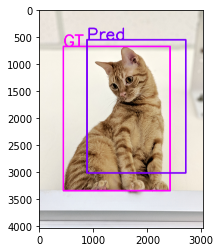

In [ ]:
img = cv2.imread('cat.jpg')

gt_box = [449, 673, 2417, 3341]  # x1, y1, x2, y2
pred_box = [885, 550, 2705, 3013]  # x1, y1, x2, y2

cv2.rectangle(img, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), (255, 0, 255), 30)
cv2.putText(img=img, text='GT', org=(gt_box[0], gt_box[1]), fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale=10, color=(255, 0, 255),thickness=30)

cv2.rectangle(img, (pred_box[0], pred_box[1]), (pred_box[2], pred_box[3]), (255, 0, 125), 30)
cv2.putText(img=img, text='Pred', org=(pred_box[0], pred_box[1]), fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale=10, color=(255, 0, 125),thickness=30)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# cv2.imwrite('output.jpg', img)


# IoU

IoU 為物件偵測中的一種評估指標，用於表示兩個物件框 Ground Truth 的 bounding box 和 predict 的 bounding box 之間的重合度。計算方式為兩個物件框之間的**"交集"** 除以 兩個物件框之間的**"聯集"**


<img src="https://github.com/chingi071/AIoT_object_detection_tutorial/blob/main/chapter2/pictures/001.jpg?raw=true" width=800>


In [ ]:
# GT ∩ Pred

left = max(gt_box[0], pred_box[0])
right = min(gt_box[2], pred_box[2])
top = max(gt_box[1], pred_box[1])
bottom = min(gt_box[3], pred_box[3])

inter_w = max(right - left, 0)
inter_h = max(bottom - top, 0)
inter_area = inter_w*inter_h

# GT ∪ Pred
gt_area = (gt_box[2]-gt_box[0]) * (gt_box[3]-gt_box[1])
pred_area = (pred_box[2]-pred_box[0]) * (pred_box[3]-pred_box[1])
area = gt_area + pred_area - inter_area

# GT ∩ Pred / GT ∪ Pred
iou = inter_area / area

In [ ]:
iou

0.5830586278975812

在物件偵測的任務上，經常會使用 0.5 作為 IoU 的閾值。也就是說當 IoU 大於 0.5，就將該預測框歸類為正樣本，反之則為負樣本。


<img src="https://github.com/chingi071/AIoT_object_detection_tutorial/blob/main/chapter2/pictures/003.jpg?raw=true" width=800>



# Confusion Matrix

假設我們要預測的類別為兩類：是貓 (label=1)、不是貓 (label=0)

* TP (True Positive)：該類別實際是貓，預測也是貓 (真陽性，表示檢測正確)。

* FP (False Positive)：該類別實際不是貓，預測成是貓 (真陰性，表示誤檢)。

* FN (False Negative)：該類別實際是貓，預測為不是貓 (假陰性，表示漏檢)。

* TN (True Negative)：該類別實際不是貓，預測也不是貓 (假陽性，不需要被檢測的地方沒被檢測出來，ex: 背景，在物件偵測中該指標不會用到)。






<img src="https://github.com/chingi071/AIoT_object_detection_tutorial/blob/main/chapter2/pictures/007.jpg?raw=true" width=400>

以二分類為例，假設目前總共有十個值

* ground_truth 表示是否為貓 -> 是貓 (label=1)、不是貓 (label=0)

* pred_score 為預測出是否為貓的機率

* threshold 設定為 0.5


In [ ]:
ground_truth = np.array([1, 1, 0, 1, 0, 0, 1, 1, 0, 0])
pred_score = np.array([0.8, 0.4, 0.1, 0.7, 0.6, 0.2, 0.9, 0.8, 0.6, 0.3])

In [ ]:
threshold = 0.5
pred_label = np.where(pred_score > threshold, 1, 0)
pred_label

array([1, 0, 0, 1, 1, 0, 1, 1, 1, 0])

In [ ]:
### tp
# 所有實際與預測相同的值
gt_equal_pred = np.where(ground_truth==pred_label, 1, 0)

# 實際值與預測值相同，並且實際為真
tp = np.sum(gt_equal_pred * ground_truth)

### fn
# 所有實際為真的數量去除掉 TP
fn = np.sum(ground_truth) - tp

### fp
# 所有預測為真的數量去除掉 TP
fp = np.sum(pred_label) - tp

### tn
# 所有實際為假的值
gt_is_false = np.where(np.logical_not(ground_truth), 1, 0)

# 實際值與預測值相同，並且預測為假
tn = np.sum(gt_equal_pred * gt_is_false)

print("tp: ", tp)
print("fn: ", fn)
print("fp: ", fp)
print("tn: ", tn)

tp:  4
fn:  1
fp:  2
tn:  3


可以藉由 sklearn 計算 confusion matrix，參考: [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)


In [ ]:
tn, fp, fn, tp = confusion_matrix(ground_truth, pred_label).ravel()
print("tp: ", tp)
print("fn: ", fn)
print("fp: ", fp)
print("tn: ", tn)

tp:  4
fn:  1
fp:  2
tn:  3


接著可以將 Confusion Matrix 畫圖顯示

In [ ]:
def confusion_matrix_plot(y_true, y_pred, classes_names):
  plt.figure(figsize=(8, 6))
  classes_number = [i for i in range(len(classes_names))]
  tn, fp, fn, tp = confusion_matrix(ground_truth, pred_label, labels=classes_number).ravel()
  cf_matrix = np.array([[tp,fn],[fp,tn]])
  cf_matrix = pd.DataFrame(cf_matrix, index = classes_names, columns = classes_names)  
  sns.heatmap(cf_matrix, cmap='Blues', annot=True)
  plt.title('Confusion Matrix', fontsize=16)
  plt.xlabel('Predicted', fontsize=16)
  plt.ylabel('Actual', fontsize=16)
  plt.show()

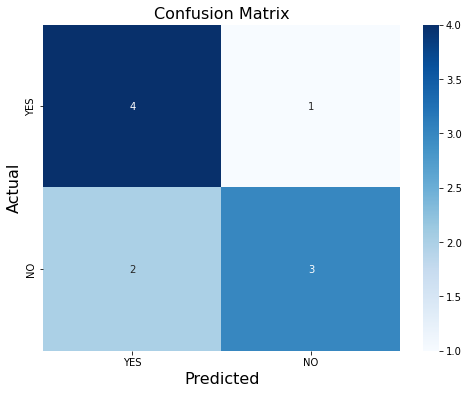

In [ ]:
confusion_matrix_plot(ground_truth, pred_label, ['YES', 'NO'])